In [1]:
from plinder.core.scores import query_index
df = query_index(columns=['entry_pdb_id'], splits=["*"])

2025-08-07 13:16:57,032 | plinder.core.utils.cpl.download_paths:24 | INFO : runtime succeeded: 0.62s
2025-08-07 13:16:58,760 | plinder.core.utils.cpl.download_paths:24 | INFO : runtime succeeded: 0.64s


In [2]:
df = df.drop_duplicates('entry_pdb_id')
for pdb in df[ df['split'] == 'test' ][ 'entry_pdb_id' ]:
    print(pdb)

3p5p
3p5z
8f1g
5oah
6oa1
6oa3
7tfp
2zz5
6oug
4xm6
1vhn
2cix
1r6w
4mmd
7akw
4yzl
1nup
3lty
3lts
1ofd
5jgq
7uxs
5ov6
5hcn
6ms8
1qwu
3qw7
3nqe
3nqm
3nqf
3nqc
3nqa
3nqd
3wgx
5m5u
5m5e
6qpl
3n2v
8jyf
6o9x
3lgm
3lgn
3qmr
3qms
2i7d
1h8v
3wjy
6xoo
6xop
5kgp
4k2f
2vfs
2vft
6e08
8e0t
4jvo
2ya3
3lu8
2fqw
1afb
2ica
3w54
3hhe
5a5w
3lv5
6eut
7cbb
4cb5
1j1m
5j1x
6ujj
1gtk
1s2g
5bzm
5bzt
5bzj
5bzl
5bzn
8bzx
5bzp
5bzq
5bzo
6jo0
2x1n
1x1i
5y4z
8qv7
4tx6
4txe
5zqx
5zq7
5ml8
4mlp
6kal
1ka1
6b2a
4aqh
6aqn
4c7w
6zbo
7zbv
1tcc
1tcb
7vjt
3ayf
6r4y
5h41
4gmc
1gm9
3arn
4d4b
6wv7
6wvh
4m1j
4og7
8og5
1lor
1los
5fux
5aog
6h7e
6fgx
8fg8
7d2f
6fl8
6gw2
6gw4
5rm2
6tez
6g27
3l4t
1l4y
8a1n
1d7c
1d7d
3hxu
2hxd
8hx7
8b6m
7z5u
1esw
6imj
7crz
4l0p
6w8z
7w81
3tay
7siy
6xhq
6gy9
2ada
5eqe
5eq9
3ikg
8q0u
5man
3maw
6z4o
3sgu
8sge
1z70
4x3l
4x3m
5qgm
3tz3
5jau
3ju4
7bhx
6apl
6apw
1r34
7t8f
5ezv
8ez1
7uas
2uag
1ua3
2zgz
4azm
4cmm
4cyj
3kqn
1xr2
8e1v
6e1a
8e1s
2dwp
3uel
6hmh
1gzf
1q91
3w0u
3lhu
3lhw
3lhy
1on6
1z82
6bto
6btn
6btp


In [3]:
import pandas as pd

df = pd.read_csv('pdbbind_rosetta.csv', index_col=0)
df

,plindersplit,hacsplit,cleansplit,lppdbbindsplit,affinity_type,dG,vague_measures,covalent,fully_relaxed,nres,...,ligaway_total_fa_sol,ligaway_total_hbond_bb_sc,ligaway_total_hbond_lr_bb,ligaway_total_hbond_sc,ligaway_total_hbond_sr_bb,ligaway_total_omega,ligaway_total_p_aa_pp,ligaway_total_pro_close,ligaway_total_rama,ligaway_total_ref
10gs,train,train,test,train,Ki,8.727473,False,False,True,416.0,...,1293.723148,-44.637822,-44.383320,-78.719777,-305.027581,33.770246,-141.491896,2.293099,-63.311837,-106.46
11gs,train,train,train,train,Ki,7.944433,False,False,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13gs,train,val,train,train,Ki,6.301885,False,False,True,418.0,...,1304.641865,-38.406367,-44.726969,-76.516610,-305.293245,32.457901,-142.517987,1.234227,-71.201047,-107.08
16pk,removed,train,train,train,Ki,7.123159,False,False,True,415.0,...,1235.450496,-75.349186,-109.866629,-53.632265,-219.000525,33.956098,-147.758026,1.668328,-98.853136,-124.01
184l,train,train,train,train,Kd,6.440284,False,False,True,162.0,...,527.193675,-17.329138,-11.902224,-28.553003,-124.906950,17.040513,-45.723548,0.339356,-58.868174,-46.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
966c,removed,train,NaN,val,Ki,10.419419,False,False,True,162.0,...,491.970002,-32.468009,-29.298600,-16.202111,-55.460115,16.192283,-56.402412,1.871896,9.933188,-21.50
9abp,train,train,NaN,train,Kd,10.912854,False,False,True,305.0,...,958.654476,-23.806635,-78.451502,-51.277298,-181.645635,95.698602,-81.593168,2.096123,-17.452140,-75.13
9hvp,NaN,train,train,train,Ki,11.385909,False,False,True,198.0,...,496.911813,-24.357985,-93.979846,-24.354186,-30.178365,30.290439,-78.683041,1.832259,-25.137098,-74.66
9icd,removed,train,train,train,Kd,5.324232,False,False,True,828.0,...,2519.132896,-115.354242,-208.133379,-143.796732,-433.739054,146.341119,-261.575721,5.276185,-80.114737,-233.04


In [4]:
for pdb in df[df['fully_relaxed']].index:
    with open( 'pdbbind_rosetta/' + pdb + '/' + pdb + '_relax.sdf' ) as file:
        for _ in range(4):
            line = file.readline()
        if 'V3000' in line:
            print(pdb, line)

1esz   0  0  0  0  0  0  0  0  0  0999 V3000



1k2v   0  0  0  0  0  0  0  0  0  0999 V3000



In [5]:
filters = [
    ('affinity_type', lambda x: x['affinity_type'] != 'IC50'),
    ('vague_measures', lambda x: ~x['vague_measures']),
    ('covalent', lambda x: ~x['covalent']),
    ('fully_relaxed', lambda x: x['fully_relaxed']),
    ('qed', lambda x: x['qed'] >= 0.2),
    ('has_rare_elem', lambda x: x['has_rare_element'] == False),
    ('rmsd_RelToCry', lambda x: x['rmsd_relax_to_crystal'] <= 4.0),
    ('relax_idelta', lambda x: x['relax_idelta_score'] >= -100000)
]
total = df.shape[0]
filter_impact = []
for f_name, f in filters:
    remaining = df[f(df)].shape[0]
    filter_impact.append((f_name,total-remaining))

filter_impact.sort(key=lambda x: x[1])
print("--- Filters sorted by removed IDs")
for fname, diff in filter_impact:
    print( fname, diff )

print()
print("--- Total size after iterative filter appliance")
df_f = df
for fname, diff in filter_impact:
    for f_name, f in filters:
        if fname == f_name:
            break
    prev = df_f.shape[0]
    df_f = df_f[f(df_f)]
    print(fname, df_f.shape[0], prev - df_f.shape[0])

names = []
removed_ids = []

for f_name, f in filters:
    names.append(f_name)
    removed_ids.append( list(df[~f(df)].index) )

padding = 15
print()
print("--- Overlap of removed IDs")
print(" ".rjust(padding), "".join([n.rjust( padding ) for n in names]), sep='')
for i in range(len(names)):
    print(names[i].rjust(padding), end='')
    for j in range(0, len(names)):
        print( str(len( [x for x in removed_ids[i] if x in removed_ids[j]] )).rjust(padding), end='' )
    print()

--- Filters sorted by removed IDs
vague_measures 504
has_rare_elem 834
covalent 893
relax_idelta 911
fully_relaxed 955
rmsd_RelToCry 1095
affinity_type 7190
qed 7648

--- Total size after iterative filter appliance
vague_measures 18939 504
has_rare_elem 18125 814
covalent 17290 835
relax_idelta 17177 113
fully_relaxed 17110 67
rmsd_RelToCry 16958 152
affinity_type 10748 6210
qed 6305 4443

--- Overlap of removed IDs
                 affinity_type vague_measures       covalent  fully_relaxed            qed  has_rare_elem  rmsd_RelToCry   relax_idelta
  affinity_type           7190            228            480            260           2297            244            310            262
 vague_measures            228            504             20             23            185             20             28             21
       covalent            480             20            893             52            260             39            102             54
  fully_relaxed            260      

In [6]:

splits = ['plindersplit', 
          'hacsplit', 
          'cleansplit', 
          'lppdbbindsplit']
padding = 15
clean_random_splitting = 0.9

print("--- Split sizes unfiltered")
print("Total IDs:", df.shape[0])
print(" ".rjust(padding), "".join([s.rjust( padding ) for s in splits]), sep='')
for t in ['train', 'val', 'test']:
    print(t.rjust(padding), end='')
    for s in splits:
        size = df[ df[s] == t ][s].shape[0]
        if s == 'cleansplit':
            if t == 'train':
                size = int(size * clean_random_splitting)
            elif t == 'val':
                size = int((1-clean_random_splitting) * df[ df[s] == 'train' ][s].shape[0])
        print(  str(size).rjust( padding ), end='' )
    print()

df_f = df
selected_filters = ['vague_measures', 'covalent', 'fully_relaxed', 'has_rare_elem', 'rmsd_RelToCry', 'relax_idelta']
for f_name, f in filters:
    if f_name not in selected_filters:
        continue
    df_f = df_f[f(df_f)]

print()
print("--- Split sizes filtered")
print("Total IDs after selected filters:", df_f.shape[0])
print(" ".rjust(padding), "".join([s.rjust( padding ) for s in splits]), sep='')
for t in ['train', 'val', 'test']:
    print(t.rjust(padding), end='')
    for s in splits:
        if t != 'test':
            size = df_f[ df_f[s] == t ][s].shape[0]
        else:
            size = df_f[ (df_f[s] == t) & (df_f['affinity_type'] != 'IC50') ][s].shape[0]
        if s == 'cleansplit':
            if t == 'train':
                size = int(size * clean_random_splitting)
            elif t == 'val':
                size = int((1-clean_random_splitting) * df_f[ df_f[s] == 'train' ][s].shape[0])
        print(  str(size).rjust( padding ), end='' )
    print()

--- Split sizes unfiltered
Total IDs: 19443
                  plindersplit       hacsplit     cleansplit lppdbbindsplit
          train          12025          18818          14420          11513
            val             40            300           1602           2422
           test             91            290            167           4860

--- Split sizes filtered
Total IDs after selected filters: 16958
                  plindersplit       hacsplit     cleansplit lppdbbindsplit
          train          10645          16394          12663           9705
            val             32            264           1406           2159
           test             38            283            157           2447


In [7]:
df['vague_measures'].value_counts()

vague_measures
False    18939
True       504
Name: count, dtype: int64

array([[<Axes: title={'center': 'rmsd_relax_to_crystal'}>]], dtype=object)

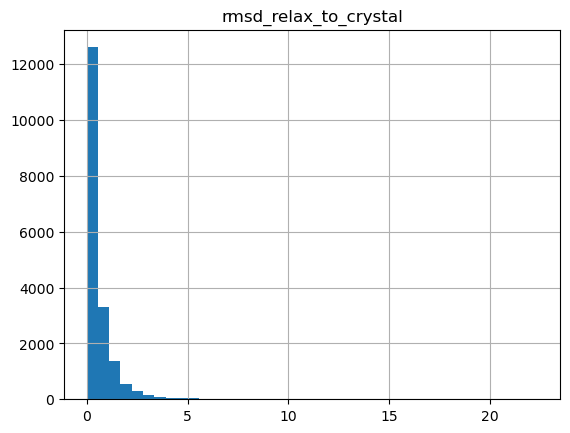

In [8]:
df.hist(column='rmsd_relax_to_crystal', bins=40)

[Text(1, 0, 'Crystal'), Text(2, 0, 'Relax')]

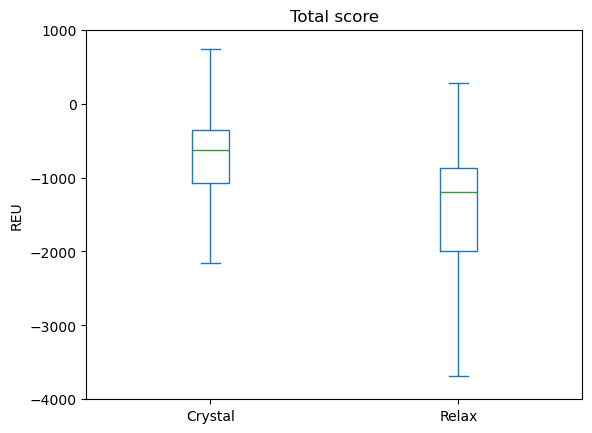

In [9]:
bp = df.plot.box(column=['crystal_total_score','relax_total_score'], ylabel='REU', title='Total score', showfliers=False, ylim=(-4000, 1000))
bp.set_xticklabels(['Crystal', 'Relax'])

[Text(1, 0, 'Crystal'), Text(2, 0, 'Relax')]

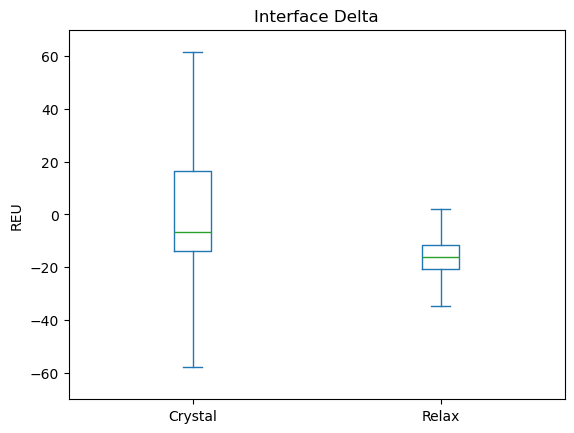

In [10]:
bp = df.plot.box(column=['crystal_idelta_score','relax_idelta_score'], ylabel='REU', title='Interface Delta', showfliers=False, ylim=(-70, 70))
bp.set_xticklabels(['Crystal', 'Relax'])

In [11]:
df['total_score_difference'] = (df['crystal_total_score'] - df['relax_total_score']).abs()
df['idelta_score_difference'] = (df['crystal_idelta_score'] - df['relax_idelta_score']).abs()

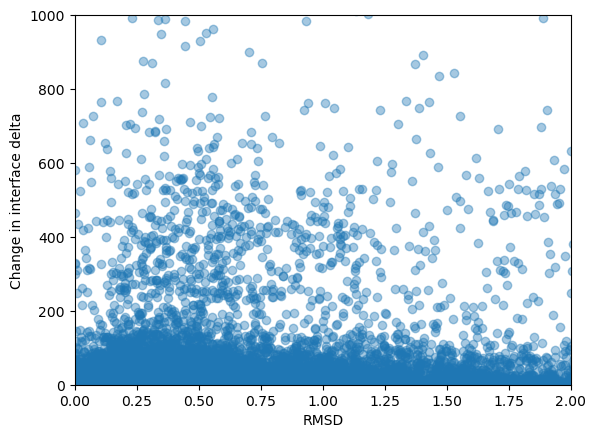

In [12]:
#df.plot.scatter('rmsd_relax_to_crystal', 'total_score_difference', ylim=(0,5000) )

from matplotlib import pyplot as plt

# crystal_idelta_score,relax_idelta_score
# relax_total_score-ligaway_total_score

plt.scatter(df.rmsd_relax_to_crystal, df.idelta_score_difference, alpha=0.4)
plt.xlim(0,2)
plt.ylim(0,1000)
plt.xlabel('RMSD')
plt.ylabel('Change in interface delta')
plt.show()

In [13]:
df[~df['rmsd_relax_to_crystal'].isna()]

,plindersplit,hacsplit,cleansplit,lppdbbindsplit,affinity_type,dG,vague_measures,covalent,fully_relaxed,nres,...,ligaway_total_hbond_lr_bb,ligaway_total_hbond_sc,ligaway_total_hbond_sr_bb,ligaway_total_omega,ligaway_total_p_aa_pp,ligaway_total_pro_close,ligaway_total_rama,ligaway_total_ref,total_score_difference,idelta_score_difference
10gs,train,train,test,train,Ki,8.727473,False,False,True,416.0,...,-44.383320,-78.719777,-305.027581,33.770246,-141.491896,2.293099,-63.311837,-106.46,496.186472,13.771504
13gs,train,val,train,train,Ki,6.301885,False,False,True,418.0,...,-44.726969,-76.516610,-305.293245,32.457901,-142.517987,1.234227,-71.201047,-107.08,530.979562,38.458711
16pk,removed,train,train,train,Ki,7.123159,False,False,True,415.0,...,-109.866629,-53.632265,-219.000525,33.956098,-147.758026,1.668328,-98.853136,-124.01,529.309862,58.570112
184l,train,train,train,train,Kd,6.440284,False,False,True,162.0,...,-11.902224,-28.553003,-124.906950,17.040513,-45.723548,0.339356,-58.868174,-46.02,312.451631,13.132691
185l,train,train,train,train,Kd,4.825667,False,False,True,162.0,...,-11.077210,-27.743668,-127.712030,16.300931,-44.540580,0.318245,-55.181607,-46.02,231.439983,2.358850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
966c,removed,train,NaN,val,Ki,10.419419,False,False,True,162.0,...,-29.298600,-16.202111,-55.460115,16.192283,-56.402412,1.871896,9.933188,-21.50,510.453500,3.117461
9abp,train,train,NaN,train,Kd,10.912854,False,False,True,305.0,...,-78.451502,-51.277298,-181.645635,95.698602,-81.593168,2.096123,-17.452140,-75.13,1122.680686,6.121583
9hvp,NaN,train,train,train,Ki,11.385909,False,False,True,198.0,...,-93.979846,-24.354186,-30.178365,30.290439,-78.683041,1.832259,-25.137098,-74.66,910.224190,18.973606
9icd,removed,train,train,train,Kd,5.324232,False,False,True,828.0,...,-208.133379,-143.796732,-433.739054,146.341119,-261.575721,5.276185,-80.114737,-233.04,1584.298234,47.086374


In [14]:
df[df['rmsd_relax_to_crystal'] < 2]

,plindersplit,hacsplit,cleansplit,lppdbbindsplit,affinity_type,dG,vague_measures,covalent,fully_relaxed,nres,...,ligaway_total_hbond_lr_bb,ligaway_total_hbond_sc,ligaway_total_hbond_sr_bb,ligaway_total_omega,ligaway_total_p_aa_pp,ligaway_total_pro_close,ligaway_total_rama,ligaway_total_ref,total_score_difference,idelta_score_difference
10gs,train,train,test,train,Ki,8.727473,False,False,True,416.0,...,-44.383320,-78.719777,-305.027581,33.770246,-141.491896,2.293099,-63.311837,-106.46,496.186472,13.771504
13gs,train,val,train,train,Ki,6.301885,False,False,True,418.0,...,-44.726969,-76.516610,-305.293245,32.457901,-142.517987,1.234227,-71.201047,-107.08,530.979562,38.458711
16pk,removed,train,train,train,Ki,7.123159,False,False,True,415.0,...,-109.866629,-53.632265,-219.000525,33.956098,-147.758026,1.668328,-98.853136,-124.01,529.309862,58.570112
184l,train,train,train,train,Kd,6.440284,False,False,True,162.0,...,-11.902224,-28.553003,-124.906950,17.040513,-45.723548,0.339356,-58.868174,-46.02,312.451631,13.132691
185l,train,train,train,train,Kd,4.825667,False,False,True,162.0,...,-11.077210,-27.743668,-127.712030,16.300931,-44.540580,0.318245,-55.181607,-46.02,231.439983,2.358850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
966c,removed,train,NaN,val,Ki,10.419419,False,False,True,162.0,...,-29.298600,-16.202111,-55.460115,16.192283,-56.402412,1.871896,9.933188,-21.50,510.453500,3.117461
9abp,train,train,NaN,train,Kd,10.912854,False,False,True,305.0,...,-78.451502,-51.277298,-181.645635,95.698602,-81.593168,2.096123,-17.452140,-75.13,1122.680686,6.121583
9hvp,NaN,train,train,train,Ki,11.385909,False,False,True,198.0,...,-93.979846,-24.354186,-30.178365,30.290439,-78.683041,1.832259,-25.137098,-74.66,910.224190,18.973606
9icd,removed,train,train,train,Kd,5.324232,False,False,True,828.0,...,-208.133379,-143.796732,-433.739054,146.341119,-261.575721,5.276185,-80.114737,-233.04,1584.298234,47.086374


In [15]:
df['plindersplit'].value_counts()

plindersplit
train         12025
removed        4156
unassigned     2370
test             91
val              40
Name: count, dtype: int64

In [16]:
df['hacsplit'].value_counts()

hacsplit
train    18818
val        300
test       290
Name: count, dtype: int64

In [17]:
df['cleansplit'].value_counts()

cleansplit
train    16023
test       167
Name: count, dtype: int64

In [18]:
df['lppdbbindsplit'].value_counts()

lppdbbindsplit
train    11513
test      4860
val       2422
Name: count, dtype: int64

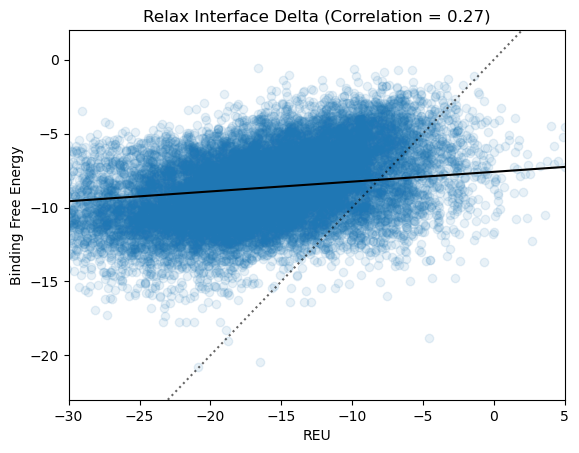

In [60]:
from matplotlib import pyplot as plt
import numpy as np

# crystal_idelta_score,relax_idelta_score
# relax_total_score-ligaway_total_score

#plt.scatter(-df_f.dG, df_f.relax_total_score - df_f.ligaway_total_score, alpha=0.1)
#plt.title('Bound-Unbound-Delta')
#plt.scatter(-df_f.dG, df_f.relax_total_score - df_f.ligaway_total_score, alpha=0.1)
#plt.title('Bound-Unbound-Delta')
 
title = 'Relax Interface Delta'
x_data = df_f['relax_idelta_score']
y_data = -df_f['dG']

correlation = x_data.corr(y_data)
slope, intercept = np.polyfit(x_data, y_data, 1)
fit_line = slope * np.arange(-150,50) + intercept
#perfect_line = 

plt.title(title + f' (Correlation = {correlation:.2f})')
plt.scatter(x_data, y_data, alpha=0.1, label='Data')
plt.plot(np.arange(-150,50), fit_line, color='black', label='Fit')
plt.xlim( -30, 5 )
plt.ylim(-23, 2)
plt.ylabel('Binding Free Energy')
plt.xlabel('REU')
plt.axline( [0,0], [1,1], color = 'black', alpha=0.6, linestyle=':' )
plt.show()

<Figure size 640x480 with 0 Axes>

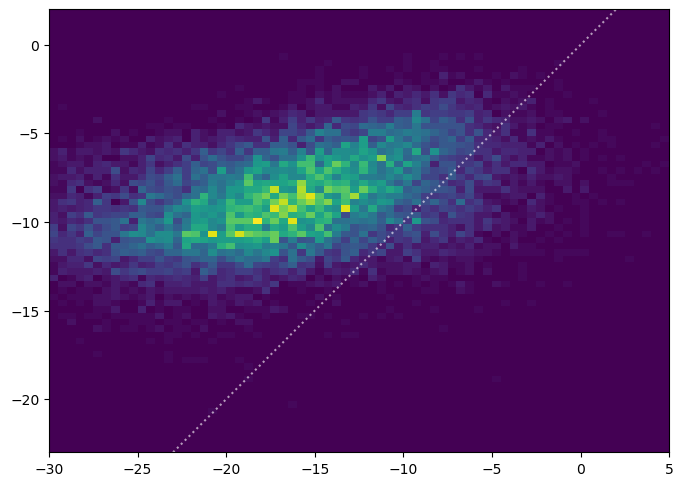

In [61]:
heatmap, xedges, yedges = np.histogram2d(x_data, y_data, bins=70, range=((-30,5,),(-23,2)))
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.figure(figsize=(8,6))
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.axline( [0,0], [1,1], color = 'white', alpha=0.6, linestyle=':' )
plt.show()

In [21]:
extent

[-100, 20, -23, 2]

In [22]:
import numpy as np
import scipy
import scipy.stats


for split in splits:
    print("---", split)
    pred_names = [ 'crystal_idelta', '  relax_idelta', '    real_delta' ]

    dG = -np.array(df_f[df_f[split] == 'test'].dG)
    preds = [ np.array(df_f[df_f[split] == 'test'].relax_idelta_score),
            np.array(df_f[df_f[split] == 'test'].relax_idelta_score), 
            np.array(df_f[df_f[split] == 'test'].relax_total_score) - np.array(df_f[df_f[split] == 'test'].ligaway_total_score)
    ]

    for i in range(3):
        print( pred_names[i],
            f'rmse: {np.sqrt( np.mean( (preds[i]-dG)**2 ) ):.4f}',
            f'mae: {np.mean( np.abs(preds[i]-dG) ):.4f}',
            f'pcc: {scipy.stats.pearsonr(preds[i], dG)[0]:.4f}',)

--- plindersplit
crystal_idelta rmse: 9.9053 mae: 8.3071 pcc: 0.3373
  relax_idelta rmse: 9.9053 mae: 8.3071 pcc: 0.3373
    real_delta rmse: 11.6472 mae: 7.2317 pcc: 0.1596
--- hacsplit
crystal_idelta rmse: 9.2034 mae: 8.0314 pcc: 0.5656
  relax_idelta rmse: 9.2034 mae: 8.0314 pcc: 0.5656
    real_delta rmse: 8.2719 mae: 6.7970 pcc: 0.4671
--- cleansplit
crystal_idelta rmse: 9.0230 mae: 7.5259 pcc: 0.5933
  relax_idelta rmse: 9.0230 mae: 7.5259 pcc: 0.5933
    real_delta rmse: 7.7688 mae: 6.2433 pcc: 0.5485
--- lppdbbindsplit
crystal_idelta rmse: 9.7950 mae: 7.9595 pcc: 0.3285
  relax_idelta rmse: 9.7950 mae: 7.9595 pcc: 0.3285
    real_delta rmse: 11.2771 mae: 7.1897 pcc: 0.2138


(16958, 20)


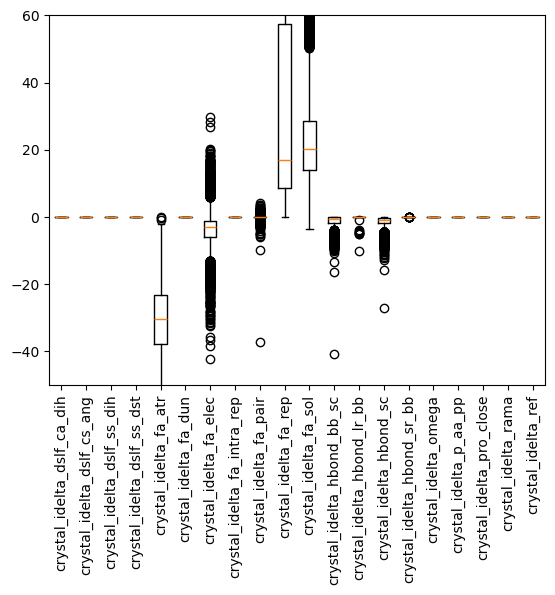

In [23]:
mask = (df_f.columns.str.contains('crystal_idelta_*')) & ~(df_f.columns.str.contains('chainbreak')) & ~(df_f.columns.str.contains('constraint')) & ~(df_f.columns.str.contains('constraint')) & (df_f.columns != 'crystal_idelta_score')
names = df_f.columns[mask]
raw_crystal_idelta = np.array( df_f.loc[:, mask ] )
print(raw_crystal_idelta.shape)
plt.boxplot([ raw_crystal_idelta[:,i] for i in range(len(names))],labels=names)
plt.xticks(rotation=90)
plt.ylim( -50,60 )
plt.show()

(16958, 20)


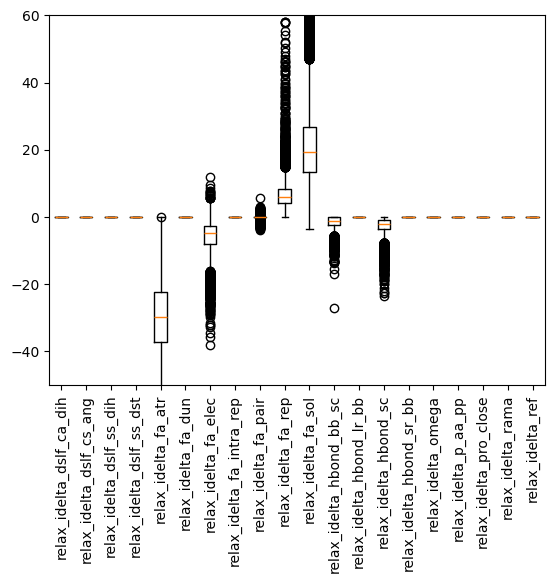

In [24]:
mask = (df_f.columns.str.contains('relax_idelta_*')) & ~(df_f.columns.str.contains('chainbreak')) & ~(df_f.columns.str.contains('constraint')) & ~(df_f.columns.str.contains('constraint')) & (df_f.columns != 'relax_idelta_score')
names = df_f.columns[mask]
raw_relax_idelta = np.array( df_f.loc[:, mask ] )
print(raw_relax_idelta.shape)
plt.boxplot([ raw_relax_idelta[:,i] for i in range(len(names))],labels=names)
plt.xticks(rotation=90)
plt.ylim( -50,60 )
plt.show()

(16958, 20)


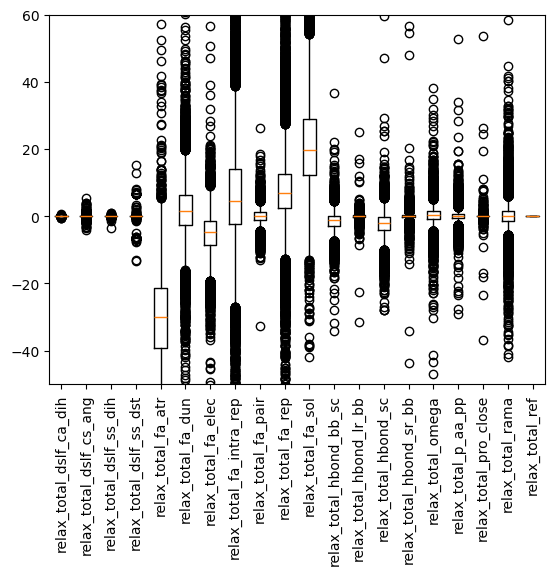

In [25]:
mask_relax = (df_f.columns.str.contains('relax_total_*')) & ~(df_f.columns.str.contains('chainbreak')) & ~(df_f.columns.str.contains('constraint')) & (df_f.columns != 'relax_total_score')
names = df_f.columns[mask_relax]
raw_relax_total = np.array( df_f.loc[:, mask_relax ] )

mask_ligaway = (df_f.columns.str.contains('ligaway_total_*')) & ~(df_f.columns.str.contains('chainbreak')) & ~(df_f.columns.str.contains('constraint')) & (df_f.columns != 'ligaway_total_score')
raw_ligaway_total = np.array( df_f.loc[:, mask_ligaway ] )

raw_real_delta = raw_relax_total - raw_ligaway_total

print(raw_real_delta.shape)
plt.boxplot([ raw_real_delta[:,i] for i in range(len(names))],labels=names)
plt.xticks(rotation=90)
plt.ylim( -50,60 )
plt.show()

In [26]:
import torch
from torch.utils.data import Dataset, DataLoader

class RosettaEnergies( Dataset ):

    def __init__( self, energies, dGs ):
        self.energies = torch.tensor( energies, dtype=torch.float32 )
        self.dGs = torch.tensor( dGs, dtype=torch.float32 )
        assert len( self.dGs ) == len( self.energies ), "Energies and dGs differ in length"

    def __len__(self):
        return len(self.dGs)
    
    def __getitem__(self, idx):
        return self.energies[idx], self.dGs[idx]
    
dG = -np.array(df_f.dG)



In [27]:
t = torch.zeros(20)
mask = raw_relax_idelta[0].nonzero()[0]
t[mask] = 1
t

tensor([0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0.,
        0., 0.])

In [28]:
from torch import nn
import copy
import torch.nn.utils.parametrize as parametrize

class SoftplusParameterization(nn.Module):
    def forward(self, X):
        return nn.functional.softplus(X)

model = nn.Linear(20,1,bias=False)
parametrize.register_parametrization(model, "weight", SoftplusParameterization())
assert torch.all(model.weight>0)

learning_rate = 0.001
epochs = 2000
batch_size = 512

split = 'lppdbbindsplit'
energies = raw_relax_idelta

train_mask = np.array(df_f[split] == 'train')
train_set = RosettaEnergies( energies[train_mask], dG[train_mask] )
train_loader = DataLoader( train_set, batch_size=batch_size, shuffle=True )

val_mask = np.array(df_f[split] == 'val')
val_set = RosettaEnergies( energies[val_mask], dG[val_mask] )
val_loader = DataLoader( val_set, batch_size=batch_size, shuffle=True )

test_mask = np.array(df_f[split] == 'test')
test_set = RosettaEnergies( energies[test_mask], dG[test_mask] )
test_loader = DataLoader( test_set, batch_size=10000, shuffle=True )

loss_fn = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, amsgrad=True)

device = 'cuda'
model = model.to(device)
print("Learnable params:", sum(p.numel() for p in model.parameters() if p.requires_grad))

best_val_loss = 9999999.99
best_val_model = copy.deepcopy(model)
best_epoch = -1

for e in range(1, epochs+1):

    inform = e % 10 == 0

    model.train()
    mse = 0
    mae = 0
    total_loss = 0
    steps = 0
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)
        pred = model(x).squeeze()
        loss = loss_fn( pred, y )

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        mse += torch.mean( (pred-y)**2 )
        mae += torch.mean( torch.abs( pred - y ) )
        total_loss += loss.item()
        steps += 1
        

    mae = mae / steps
    rmse = torch.sqrt( mse / steps )
    total_loss = total_loss / steps
    if inform: print( f"train loss: {total_loss:>7.10f} rmse: {rmse:>5.4f} mae: {mae:>5.4f} [{e:>5d}/{epochs:>5d}]" )

    model.eval()
    with torch.no_grad():
        mse = 0
        mae = 0
        total_loss = 0
        steps = 0
        for x, y in val_loader:
            x = x.to(device)
            y = y.to(device)
            pred = model(x).squeeze()
            loss = loss_fn( pred, y )

            mse += torch.mean( (pred-y)**2 )
            mae += torch.mean( torch.abs( pred - y ) )
            total_loss += loss.item()
            steps += 1

        mae = mae / steps
        rmse = torch.sqrt( mse / steps )
        total_loss = total_loss / steps
        if total_loss < best_val_loss:
            best_val_loss = total_loss
            best_val_model = copy.deepcopy(model)
            best_epoch = e
        if inform: print( f"valid loss: {total_loss:>7.10f} rmse: {rmse:>5.4f} mae: {mae:>5.4f} [{e:>5d}/{epochs:>5d}]" )

print('Selected model with best validation loss from epoch', best_epoch)
print(best_val_loss)
mask = raw_relax_idelta[0].nonzero()[0]
print(best_val_model.weight[0][mask])
best_val_model.eval()

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        y = y.to(device)
        pred = best_val_model(x).squeeze()
        loss = loss_fn( pred, y )

        rmse = torch.sqrt(torch.mean( (pred-y)**2 ))
        mae = torch.mean( torch.abs( pred - y ) )
        total_loss = loss.item()
        pearson = scipy.stats.pearsonr(pred.cpu().numpy(), y.cpu())[0]

    print( f"Test loss: {total_loss:>7.10f} rmse: {rmse:>5.4f} mae: {mae:>5.4f} pcc: {pearson:>5.4f}" )

#print(model.weight)
#print(model.bias)

Learnable params: 20
train loss: 4.3315395932 rmse: 14.6097 mae: 4.3315 [   10/ 2000]
valid loss: 3.5232316971 rmse: 4.9095 mae: 3.5232 [   10/ 2000]
train loss: 4.1239211308 rmse: 13.4362 mae: 4.1239 [   20/ 2000]
valid loss: 3.4197140694 rmse: 4.7594 mae: 3.4197 [   20/ 2000]
train loss: 3.9222515382 rmse: 12.2792 mae: 3.9223 [   30/ 2000]
valid loss: 3.2308614731 rmse: 4.4905 mae: 3.2309 [   30/ 2000]
train loss: 3.7391116745 rmse: 11.2155 mae: 3.7391 [   40/ 2000]
valid loss: 3.1063798428 rmse: 4.2872 mae: 3.1064 [   40/ 2000]
train loss: 3.5772495395 rmse: 10.2465 mae: 3.5772 [   50/ 2000]
valid loss: 2.9735117435 rmse: 4.0590 mae: 2.9735 [   50/ 2000]
train loss: 3.4358298402 rmse: 9.3938 mae: 3.4358 [   60/ 2000]
valid loss: 2.8786434650 rmse: 3.8966 mae: 2.8786 [   60/ 2000]
train loss: 3.3163899121 rmse: 8.6811 mae: 3.3164 [   70/ 2000]
valid loss: 2.8155368805 rmse: 3.8019 mae: 2.8155 [   70/ 2000]
train loss: 3.2096372780 rmse: 7.9766 mae: 3.2096 [   80/ 2000]
valid loss: 2.

In [52]:
print('\t\tNew\tOld\tDiff\tQuot')
print(f'fa_atr \t\t{best_val_model.weight[0][mask][0].item():.4f}\t0.8000\t{best_val_model.weight[0][mask][0].item()-0.8:.4f}\t{best_val_model.weight[0][mask][0].item()/0.8:.4f}')
print(f'fa_elec \t{best_val_model.weight[0][mask][1].item():.4f}\t0.4200\t{best_val_model.weight[0][mask][1].item()-0.42:.4f}\t{best_val_model.weight[0][mask][1].item()/0.42:.4f}')
print(f'fa_pair \t{best_val_model.weight[0][mask][2].item():.4f}\t0.8000\t{best_val_model.weight[0][mask][2].item()-0.8:.4f}\t{best_val_model.weight[0][mask][2].item()/0.8:.4f}')
print(f'fa_rep \t\t{best_val_model.weight[0][mask][3].item():.4f}\t0.4000\t{best_val_model.weight[0][mask][3].item()-0.4:.4f}\t{best_val_model.weight[0][mask][3].item()/0.4:.4f}')
print(f'fa_sol \t\t{best_val_model.weight[0][mask][4].item():.4f}\t0.6000\t{best_val_model.weight[0][mask][4].item()-0.6:.4f}\t{best_val_model.weight[0][mask][4].item()/0.6:.4f}')
print(f'hbond_bb_sc \t{best_val_model.weight[0][mask][5].item():.4f}\t1.3000\t{best_val_model.weight[0][mask][5].item()-1.3:.4f}\t{best_val_model.weight[0][mask][5].item()/1.3:.4f}')
print(f'hbond_sc \t{best_val_model.weight[0][mask][6].item():.4f}\t1.3000\t{best_val_model.weight[0][mask][6].item()-1.3:.4f}\t{best_val_model.weight[0][mask][6].item()/1.3:.4f}')

		New	Old	Diff	Quot
fa_atr 		0.3192	0.8000	-0.4808	0.3990
fa_elec 	0.0903	0.4200	-0.3297	0.2151
fa_pair 	0.0398	0.8000	-0.7602	0.0498
fa_rep 		0.0187	0.4000	-0.3813	0.0468
fa_sol 		0.1497	0.6000	-0.4503	0.2495
hbond_bb_sc 	0.0457	1.3000	-1.2543	0.0351
hbond_sc 	0.3235	1.3000	-0.9765	0.2488


In [30]:
df_f['pred_dG'] = df['relax_idelta_fa_atr'] * best_val_model.weight[0][mask][0].cpu().detach().numpy()
df_f['pred_dG'] += df['relax_idelta_fa_elec'] * best_val_model.weight[0][mask][1].cpu().detach().numpy()
df_f['pred_dG'] += df['relax_idelta_fa_pair'] * best_val_model.weight[0][mask][2].cpu().detach().numpy()
df_f['pred_dG'] += df['relax_idelta_fa_rep'] * best_val_model.weight[0][mask][3].cpu().detach().numpy()
df_f['pred_dG'] += df['relax_idelta_fa_sol'] * best_val_model.weight[0][mask][4].cpu().detach().numpy()
df_f['pred_dG'] += df['relax_idelta_hbond_bb_sc'] * best_val_model.weight[0][mask][5].cpu().detach().numpy()
df_f['pred_dG'] += df['relax_idelta_hbond_sc'] * best_val_model.weight[0][mask][6].cpu().detach().numpy()

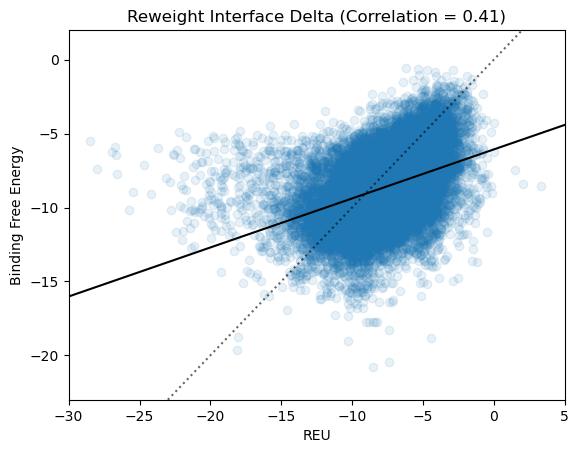

In [62]:


title = 'Reweight Interface Delta'
x_data = df_f['pred_dG']
y_data = -df_f['dG']

correlation = x_data.corr(y_data)
slope, intercept = np.polyfit(x_data, y_data, 1)
fit_line = slope * np.arange(-150,50) + intercept
#perfect_line = 

plt.title(title + f' (Correlation = {correlation:.2f})')
plt.scatter(x_data, y_data, alpha=0.1, label='Data')
plt.plot(np.arange(-150,50), fit_line, color='black', label='Fit')
plt.xlim( -30, 5 )
plt.ylim(-23, 2)
plt.ylabel('Binding Free Energy')
plt.xlabel('REU')
plt.axline( [0,0], [1,1], color = 'black', alpha=0.6, linestyle=':' )
plt.show()

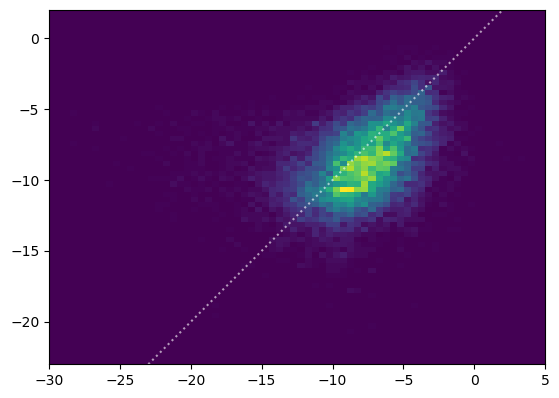

In [63]:
heatmap, xedges, yedges = np.histogram2d(x_data, y_data, bins=70, range=((-30,5,),(-23,2)))
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.axline( [0,0], [1,1], color = 'white', alpha=0.6, linestyle=':' )
plt.show()